In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
labels = os.listdir("/kaggle/input/drowsiness-dataset/train")
labels

['Closed', 'Open', 'yawn', 'no_yawn']

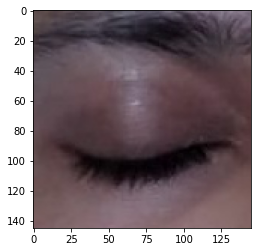

In [4]:
plt.imshow(plt.imread("/kaggle/input/drowsiness-dataset/train/Closed/_0.jpg"))

In [5]:
a = plt.imread("/kaggle/input/drowsiness-dataset/train/yawn/10.jpg")

In [6]:
a.shape

(480, 640, 3)

In [7]:
def face_for_yawn(direc="/kaggle/input/drowsiness-dataset/train", face_cas_path="/kaggle/input/prediction-images/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


In [8]:
#/kaggle/input/prediction-images/haarcascade_frontalface_default.xml

In [9]:
def get_data(dir_path="/kaggle/input/drowsiness-dataset/train", face_cas="/kaggle/input/prediction-images/haarcascade_frontalface_default.xml", eye_cas="../archive/test/haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [10]:
data_train = get_data()

2
3


In [11]:
def append_data():
#     total_data = []
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no)

In [12]:
new_data = append_data()

0
1
2
3


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [13]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

In [14]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

In [15]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [16]:
y = np.array(y)

In [17]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [18]:
len(X_test)

578

In [19]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [20]:
import keras
keras.__version__

'2.6.0'

In [21]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

In [22]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 143, 143, 256)     7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 71, 71, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 69, 69, 128)       295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        1

2023-01-12 19:59:47.206265: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-12 19:59:47.207145: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-12 19:59:47.342463: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-12 19:59:47.343316: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-12 19:59:47.344049: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [23]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

2023-01-12 19:59:51.343876: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2023-01-12 19:59:53.306493: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


43/43 [==============================] - 19s 189ms/step - loss: 1.0573 - accuracy: 0.5152 - val_loss: 0.7517 - val_accuracy: 0.7353
Epoch 2/50
43/43 [==============================] - 8s 182ms/step - loss: 0.5010 - accuracy: 0.7810 - val_loss: 0.4077 - val_accuracy: 0.8391
Epoch 3/50
43/43 [==============================] - 9s 197ms/step - loss: 0.3807 - accuracy: 0.8285 - val_loss: 0.3682 - val_accuracy: 0.8737
Epoch 4/50
43/43 [==============================] - 8s 179ms/step - loss: 0.3619 - accuracy: 0.8352 - val_loss: 0.2945 - val_accuracy: 0.8547
Epoch 5/50
43/43 [==============================] - 8s 177ms/step - loss: 0.3157 - accuracy: 0.8612 - val_loss: 0.2543 - val_accuracy: 0.9118
Epoch 6/50
43/43 [==============================] - 8s 179ms/step - loss: 0.2942 - accuracy: 0.8805 - val_loss: 0.2848 - val_accuracy: 0.9048
Epoch 7/50
43/43 [==============================] - 8s 194ms/step - loss: 0.3108 - accuracy: 0.8701 - val_loss: 0.2707 - val_accuracy: 0.8997
Epoch 8/50
43/43

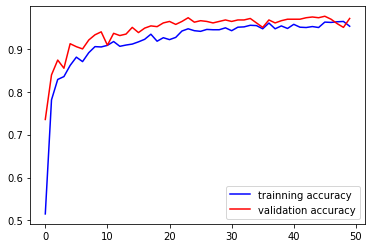

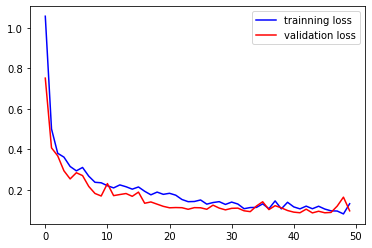

In [24]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.savefig("graph.png")
plt.show()

In [25]:
model.save("drowiness_detection_model.h5")

In [26]:
model.save("drowiness_detection_model.model")

2023-01-12 20:07:01.559617: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [27]:
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

In [28]:
prediction = classes_x
prediction

array([3, 3, 2, 3, 1, 3, 3, 2, 0, 2, 3, 3, 3, 2, 2, 2, 3, 0, 0, 2, 3, 3,
       2, 0, 0, 2, 2, 2, 3, 2, 3, 2, 3, 2, 0, 3, 3, 2, 1, 3, 3, 3, 2, 3,
       2, 2, 3, 3, 2, 3, 3, 1, 2, 1, 2, 3, 2, 2, 2, 0, 3, 3, 1, 2, 2, 3,
       2, 3, 2, 2, 1, 3, 3, 3, 2, 0, 0, 3, 1, 3, 2, 0, 3, 2, 2, 2, 2, 0,
       3, 3, 2, 3, 3, 3, 1, 0, 3, 0, 3, 3, 3, 1, 3, 1, 2, 3, 2, 1, 2, 2,
       1, 1, 2, 1, 0, 3, 3, 3, 2, 2, 3, 3, 3, 0, 1, 2, 3, 2, 2, 0, 3, 3,
       1, 3, 1, 2, 2, 3, 3, 1, 2, 2, 2, 1, 3, 3, 3, 3, 2, 0, 3, 3, 3, 3,
       3, 0, 0, 0, 3, 1, 3, 2, 2, 3, 2, 3, 3, 2, 3, 2, 3, 1, 2, 0, 3, 3,
       2, 2, 0, 2, 3, 0, 2, 0, 3, 3, 3, 1, 2, 0, 1, 3, 2, 2, 3, 2, 3, 0,
       3, 2, 3, 0, 2, 0, 0, 1, 2, 3, 2, 0, 3, 1, 2, 2, 2, 2, 1, 3, 1, 0,
       1, 0, 2, 3, 3, 3, 3, 0, 0, 2, 0, 0, 3, 3, 1, 3, 3, 0, 3, 3, 1, 0,
       0, 0, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 2, 0, 2, 2, 2, 0, 3, 3, 2, 2,
       3, 2, 2, 0, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 0, 1, 0, 3, 3, 3, 3, 2,
       2, 0, 2, 2, 2, 3, 2, 0, 2, 2, 1, 3, 2, 3, 1,

In [29]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [30]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), prediction, target_names=labels_new))

              precision    recall  f1-score   support

        yawn       0.81      0.94      0.87        63
     no_yawn       0.92      0.81      0.86        74
      Closed       0.96      0.97      0.97       215
        Open       0.98      0.96      0.97       226

    accuracy                           0.94       578
   macro avg       0.92      0.92      0.92       578
weighted avg       0.95      0.94      0.94       578



In [31]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas="/kaggle/input/prediction-images/haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("./drowiness_detection_model.h5")

In [32]:
# prepare("../input/drowsiness-dataset/train/no_yawn/1068.jpg")
prediction = model.predict([prepare("/kaggle/input/prediction-images/dandelion.jpg")])
np.argmax(prediction)

2

In [33]:
prediction = model.predict([prepare("/kaggle/input/drowsiness-dataset/train/Closed/_103.jpg")])
np.argmax(prediction)

2

In [34]:
# import IPython.display as ipd

In [35]:
# input1="/kaggle/input/prediction-images/17.jpg"

In [36]:
# fname = 'TF045.WAV'
# prediction = model.predict([prepare(input1)])
# if(np.argmax(prediction)==2 or np.argmax(prediction)==0):
#     ipd.display(ipd.Audio( '/content/drive/MyDrive/Colab Notebooks/archive/beepsound.mp3', autoplay=True))